# Lab 6 Report

Prepared by Zech Wolf

## 1. Data preparation

The dataset used is the handwritten letters dataset from EMNIST. There are 26 classes for each of the letters in the Roman alphabet. The full dataset contains over 145,000 instances. The provided training set is used as the full dataset for this report (about 88,000 instances). Each instance is a 28x28 grayscale image containing a handwritten letter.

Dataset source: https://www.kaggle.com/datasets/crawford/emnist?resource=download&select=emnist-letters-train.csv (processed into .csv format from original source)

### 1.1 Performance metrics

A possible business case for this dataset is optical character recognition (OCR), which converts text from an image into digital text on a computer. A classification model trained on this dataset could be used to process handwriting. A useful OCR deployment should be well-trained to recognize all letters of the Roman alphabet with equal accuracy. It could be argued that not all letters are equally important as not all letters are equally frequent in natural language. However, just because some letters are less frequent does not mean that mistaking them for other letters is a less significant error in individual cases. A mistake in processing a letter will still result in a misspelling or loss of information regardless of the frequency of the letter in natural language. For these reasons, I will treat the identification of all classes as equally important.

With all this in mind, the appropriate metric is accuracy, since all classes are equally important, and the dataset is balanced.

### 1.2 Cross validation method

With nearly 90,000 instances, the dataset is very large. The dataset is also approximately balanced by class. For these reasons, a stratified 80/20 split should be suitable for training and testing. The testing set will be used as validation data during training to assess validation metrics.

In practice, a model used for OCR would be pretrained on a large training set, and applied to individual documents for reading. An 80/20 split provides a large training set with about 70,000 samples, and a balanced testing set. The performance on the testing set is representative of the mean accuracy for each letter.

In [10]:
import pandas as pd

df = pd.read_csv("datasets/emnist-letters-train.csv")
df["23"] -= 1 #adjust class label to be range 0-25 instead of 1-26

In [11]:
import numpy as np

X = df.drop(columns=df.columns[0]).to_numpy(dtype=np.float32)
X = X.reshape((-1,28,28,1))  #reshape to tensor format
X /= 255 #normalize images to interval [0,1]

y = df[df.columns[0]].to_numpy()

NUM_CLASSES = 26

In [12]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=1234)

#OHE encode the labels
y_train_ohe = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

## 2. Modeling

Two CNN architectures are tested, with variations on each architecture to produce four different models

### 2.1 Data augmentation and preprocessing

The training set is augmented using random translations and random zooms. The random translation creates instances where the letter is not exactly centered, or may even be slightly cropped off. The random zooms adjust how large the letter is relative to the total image size. These augmentations should help the model generalize to more less ideal, more realistic scenarios, where letters are not all the same size or perfectly centered in the image. The augmentation is applied to the dataset as a preprocessing step before training.

In [13]:
from keras.models import Sequential
from keras.layers import RandomTranslation, RandomZoom

augment = Sequential([
    RandomTranslation(0.2, 0.2),
    RandomZoom(0.3, 0.3),
])

X_train_aug = augment(X_train, training=True)

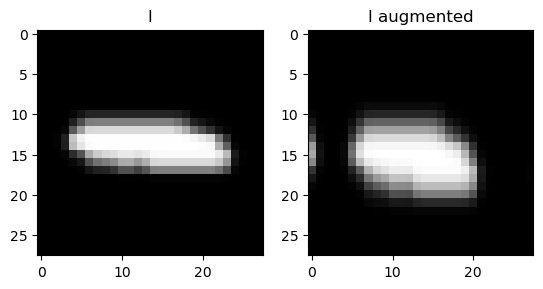

In [155]:
import matplotlib.pyplot as plt

#Show the effect of augmentation on a sample
sample = np.random.randint(0, len(X_train_aug))

plt.subplot(1,2,1)
plt.imshow(X_train[sample], cmap="gray")
plt.title(chr(y_train[sample] + 97))

plt.subplot(1,2,2)
plt.imshow(X_train_aug[sample], cmap="gray")
plt.title(chr(y_train[sample] + 97) + " augmented")
plt.show()

#### Convenience functions

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance(hist):
    plt.figure(figsize=(14,6))

    #accuracy plot
    plt.subplot(1,2,1)
    epochs = range(len(hist.epoch))
    accuracy = hist.history["accuracy"]
    val_accuracy = hist.history["val_accuracy"]

    sns.lineplot(x=epochs, y=accuracy, label="Training accuracy")
    sns.lineplot(x=epochs, y=val_accuracy, label="Validation accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epoch")

    #Loss plot
    plt.subplot(1,2,2)
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    sns.lineplot(x=epochs, y=loss, label="Training loss")
    sns.lineplot(x=epochs, y=val_loss, label="Validation loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

In [112]:
from sklearn.metrics import accuracy_score

def model_report(model, y_test, X_test=X_test):
    y_score = model.predict(X_test)
    y_pred = np.argmax(y_score, axis=1)
    print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
    return y_pred, y_score

In [17]:
#McNemars test for stat comparison
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

### 2.2 CNN Architecture 1

The first architecture is a simple setup with the following components:
* Convolution layer
* Max pooling layer
* Dense output layer

#### 2.2.1 CNN 1
The first implementation of this architecture uses a filter size of 3x3

In [18]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

cnn1 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn1.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [19]:
hist1 = cnn1.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=0)

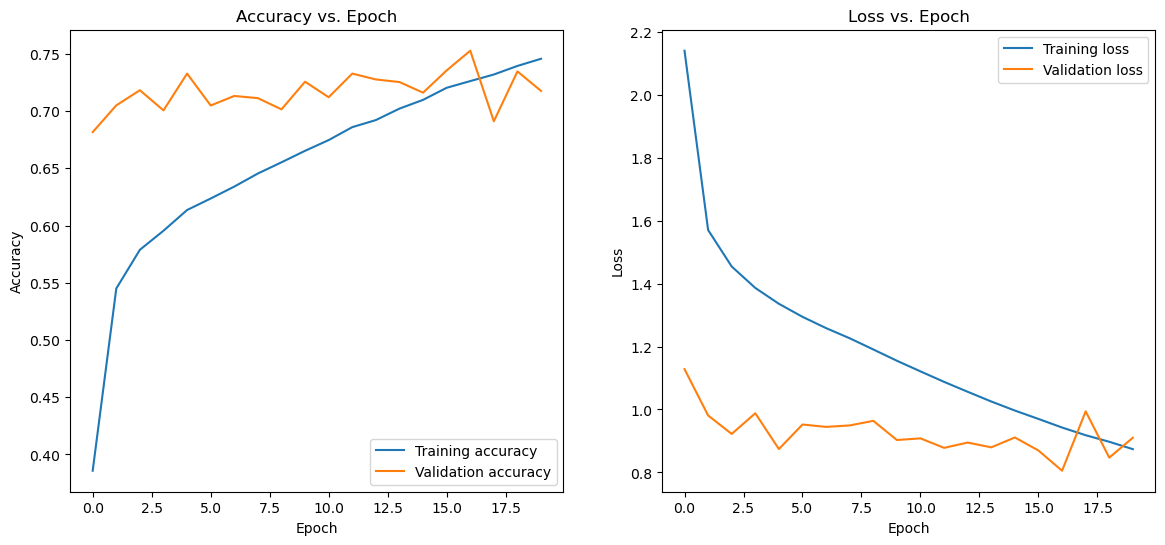

Test set accuracy: 0.7176238738738738


In [20]:
plot_performance(hist1)
y_pred_cnn1, y_score_cnn1 = model_report(cnn1, y_test)

The network appears to converge, although the validation loss starts to increase towards the end of training, which could be indicative of overfitting

#### 2.2.2 CNN 2

The second implementation of this architecture uses a larger filter size of 6x6. This should train the model to recognize larger scale features of each letter, and hopefully improve the accuracy

In [21]:
cnn2 = Sequential([
    Conv2D(filters=32, kernel_size=(6,6), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn2.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [22]:
hist2 = cnn2.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=0)

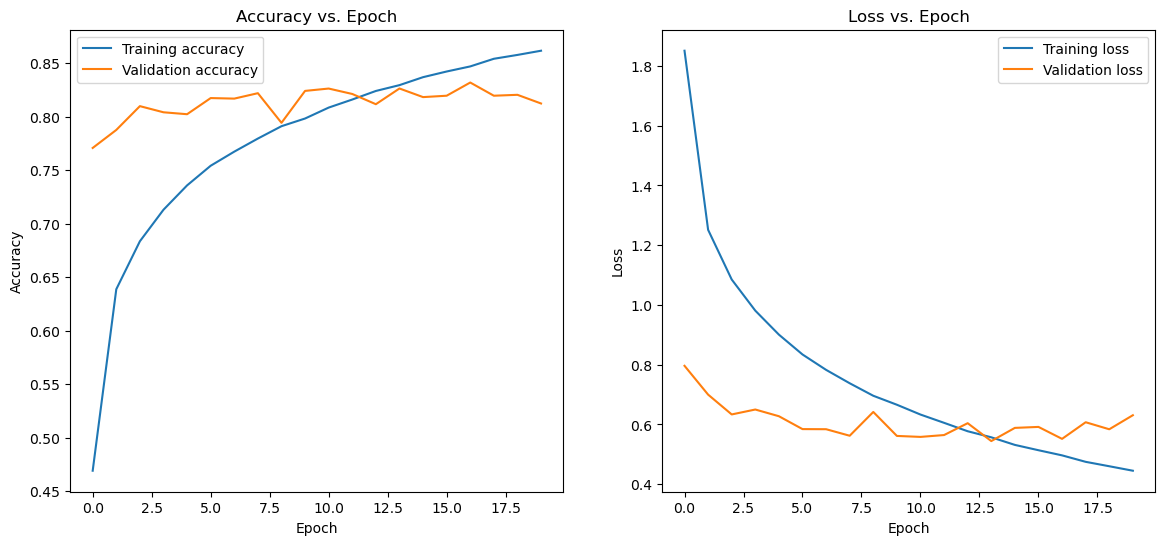

Test set accuracy: 0.8125


In [23]:
plot_performance(hist2)
y_pred_cnn2, y_score_cnn2 = model_report(cnn2, y_test)

The accuracy is better by about 10% with a larger filter size. It appears that recognizing larger scale features in each image makes a difference. Once again, the validation loss starts to dominate the training loss at the end of training, but the difference is more prominent than in CNN 1

#### 2.2.3 Statistical comparison: CNN 1 vs CNN 2

The two different implemntations of Architecture 1 are compared using McNemar's test (using critical value of $3.841$ for 95% CI)

In [24]:
print(f"CNN1 vs. CNN2: {mcnemar(y_pred_cnn1, y_pred_cnn2, y_test)}")
print(f"CNN 1 accuracy: {accuracy_score(y_test, y_pred_cnn1)}")
print(f"CNN 2 accuracy: {accuracy_score(y_test, y_pred_cnn2)}")

CNN1 vs. CNN2: 760.0793352988475
CNN 1 accuracy: 0.7176238738738738
CNN 2 accuracy: 0.8125


The result of McNemar's test is greater than the critical value, which means there is a statistical difference between the two implementations. Given the higher accuracy of CNN2, we can say that CNN2 is the better model.

### 2.3 CNN Architecture 2

The second architecture uses more convolution layers and adds more dense layers following the convolutions. The components are:
* 3x Convolution and Max Pooling layers (6x6 filters)
* 25% Dropout
* 4x Dense layers
* 50% Dropout

I also use RmsProp instead of AdaM for these implementations

#### 2.3.1 CNN 3
The first implementation of this architecture uses 32, 64, and 128 filters in the three convolution layers

In [156]:
from keras.layers import Dropout

cnn3 = Sequential([
    Conv2D(filters=32, kernel_size=(6,6), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Dropout(0.25),
    Flatten(),

    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn3.compile(optimizer="rmsprop", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [157]:
hist3 = cnn3.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=0)

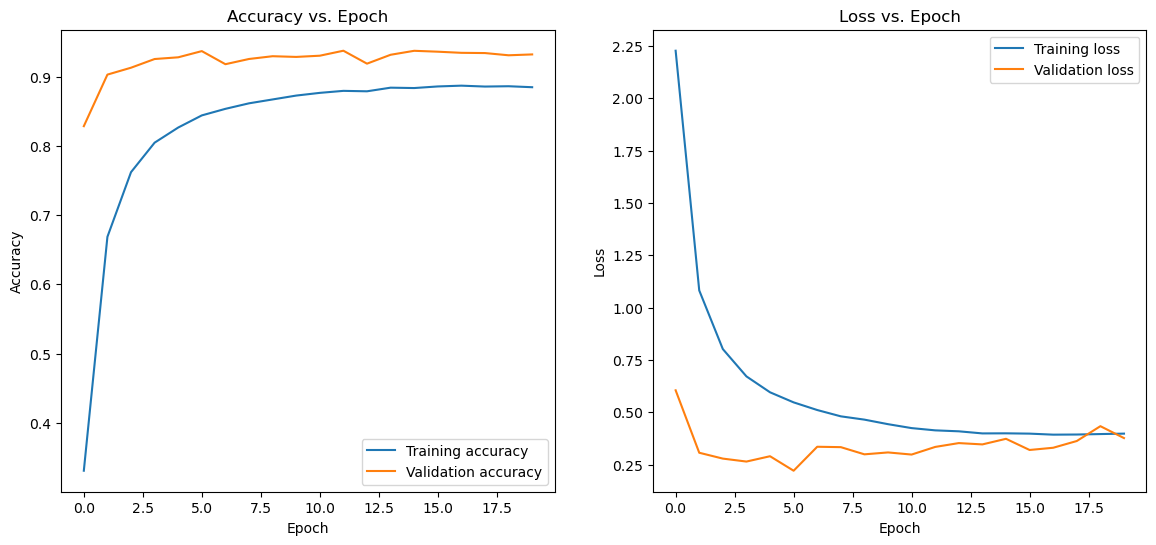

Test set accuracy: 0.9322072072072072


In [158]:
plot_performance(hist3)
y_pred_cnn3, y_score_cnn3 = model_report(cnn3, y_test)

The model converges and the accuracy is significantly improved from the best implementation of Architecture 1. Similar to previous models though, the validation accuracy flatlines not very long into training, and the validation loss even starts to increase. The model was only trained for 20 epochs to prevent overfitting because of this.

#### 2.3.2 CNN 4

The next implementation of this architecture uses a higher number of filters: 64, 128, and 256 in the respective convolution layers

In [41]:
cnn4 = Sequential([
    Conv2D(filters=64, kernel_size=(6,6), padding="same", input_shape=(28,28,1), activation="relu"),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(filters=256, kernel_size=(6,6), padding="same", activation="relu"),
    MaxPool2D(),
    Dropout(0.25),
    Flatten(),

    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn4.compile(optimizer="rmsprop", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [42]:
hist4 = cnn4.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=20, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=0)

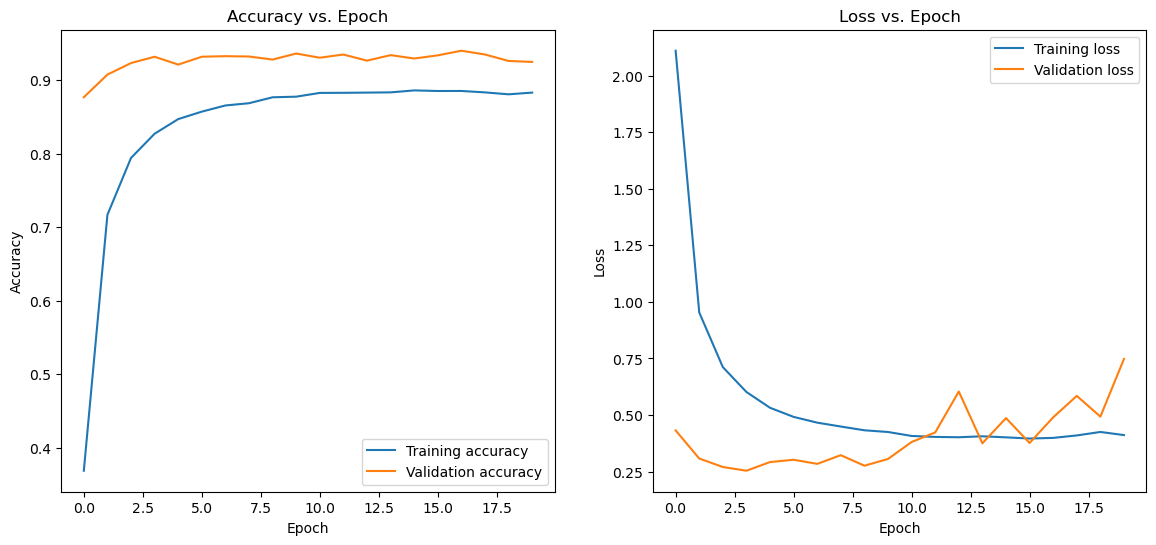

Test set accuracy: 0.9247747747747748


In [43]:
plot_performance(hist4)
y_pred_cnn4, y_score_cnn4 = model_report(cnn4, y_test)

The accuracy is comparable to CNN 3, but the validation loss starts to increase pretty substantially after about 10 epochs. It looks like an increased number of filters is not a significant advantage, but a statistical comparison is needed to make sure.

#### 2.3.3 Statistical comparison: CNN 3 vs. CNN 4

In [162]:
print(f"CNN3 vs. CNN4: {mcnemar(y_pred_cnn3, y_pred_cnn4, y_test)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")
print(f"CNN 4 accuracy: {accuracy_score(y_test, y_pred_cnn4)}")

CNN3 vs. CNN4: 16.098499061913696
CNN 3 accuracy: 0.9322072072072072
CNN 4 accuracy: 0.9247747747747748


The result of McNemar's test is greater than the critical value, so the models are statistically different. Based on the accuracy, CNN 3 is the better implementation of Architecture 2.

#### 2.3.4 Statistical comparison: CNN 2 vs. CNN 3

The best implementation of Architecture 1 (CNN 2) is compared to the best implementation of Architecture 2 (CNN 3) to find the best overall model.

In [163]:
print(f"CNN2 vs. CNN3: {mcnemar(y_pred_cnn2, y_pred_cnn3, y_test)}")
print(f"CNN 2 accuracy: {accuracy_score(y_test, y_pred_cnn2)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")

CNN2 vs. CNN3: 1496.2309476474486
CNN 2 accuracy: 0.8125
CNN 3 accuracy: 0.9322072072072072


The result is greater than the critical value, so the models are statistically different. CNN 3 had much better accuracy, so it is the best CNN overall.

#### 2.3.5 Summary comparison

CNN 3 is the best model according to the statistical comparisons. The accuracies of each model is summarized in the bar chart

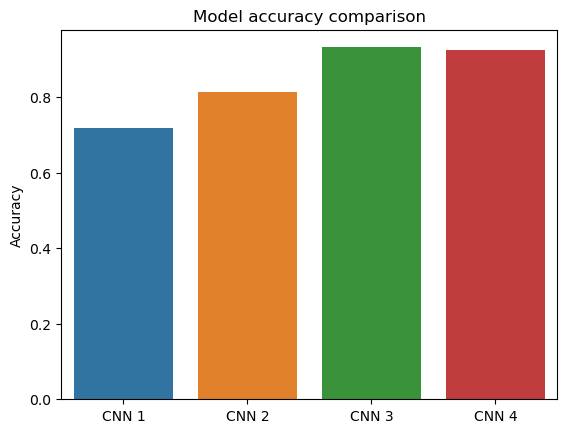

In [164]:
preds = [y_pred_cnn1, y_pred_cnn2, y_pred_cnn3, y_pred_cnn4]
accs = [accuracy_score(y_test, yhat) for yhat in preds]

sns.barplot(x=[f"CNN {i}" for i in range(1,5)], y=accs)
plt.ylabel("Accuracy")
plt.title("Model accuracy comparison")
plt.show()

The difference between Architecture 1 and 2 is clear. Using more convolution layers definitely increased the accuracy. Within Architecture 1, there were significant gains from increasing the filter size of the convolution layer. Within Architecture 2, using fewer filters per convolution layer was statistically better, although the gains in accuracy were not very impressive. Based on this, it seems that using larger filters to capture larger scale structures in the images, as well as increasing the network depth, are the most important factors for increasing accuracy.

### 2.4 Comparing to MLP

The best CNN (CNN 3) is compared to to a standard multi-layer perceptron.

In [46]:
mlp = Sequential([
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax")
])

mlp.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

In [47]:
hist_mlp = mlp.fit(X_train_aug, y_train_ohe, batch_size=128, epochs=50, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=0)

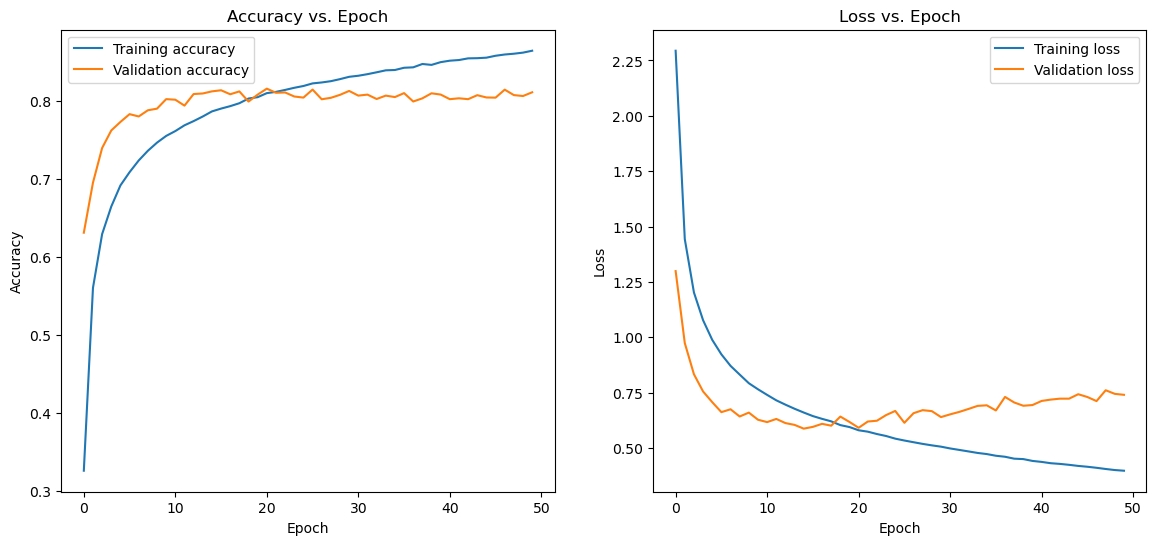

Test set accuracy: 0.8110923423423423


In [48]:
plot_performance(hist_mlp)
y_pred_mlp, y_score_mlp = model_report(mlp, y_test)

The MLP performs comparably to CNN 2 in terms of accuracy. The accuracy is about 10% worse than CNN 3 and 4 though.

#### 2.4.1 ROC curve comparison

For this multiclass problem, the ROC curve is calculated by macro-averaging so that all classes are weighted equally (the micro-average would be very similar because the dataset is well-balanced), since the classes are equally important in an OCR application business case.

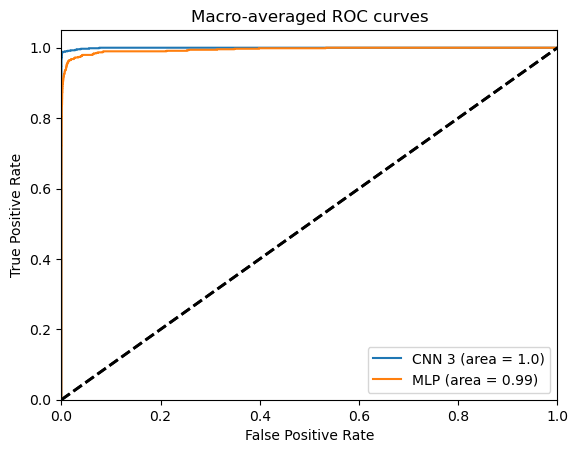

In [165]:
from sklearn.metrics import roc_curve, auc

#This code is copied and adapted from sklearn docs here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 

def plot_roc(y_score, y_test_ohe, lbl):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(
        fpr[25],
        tpr[25],
        label=f"{lbl} (area = {roc_auc['micro']:{1}.{2}})",
    )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-averaged ROC curves")
    plt.legend(loc="lower right")

#End code from sklearn docs

plot_roc(y_score_cnn3, y_test_ohe, "CNN 3")
plot_roc(y_score_mlp, y_test_ohe, "MLP")

Based on the ROC curve, CNN 3 appears to be slightly better than the MLP. It is interesting that the AUC score is very similar between the models, despite CNN 3 being much better in terms of accuracy. I suspect this is because both networks perform very well for most classes in the dataset, but there are a few problematic letters that are difficult to recognize, which bring down the overall accuracy. This would explain why the macro-averaged ROC curves show similar performance in terms of TPR and FPR, but the accuracies are quite different. The confusion matrix for each network can help explain this better.

In [69]:
from sklearn.metrics import confusion_matrix

labels = [chr(i+97) for i in range(26)]

#This code is adapted from example notebook
def cm(y_test, y_pred, title):
    cm = confusion_matrix(y_test,y_pred)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm,xticklabels=labels,yticklabels=labels, cbar=True)
    plt.title(title)

    per_class_acc = [cm[i,i] for i in range(len(cm))]
    return per_class_acc

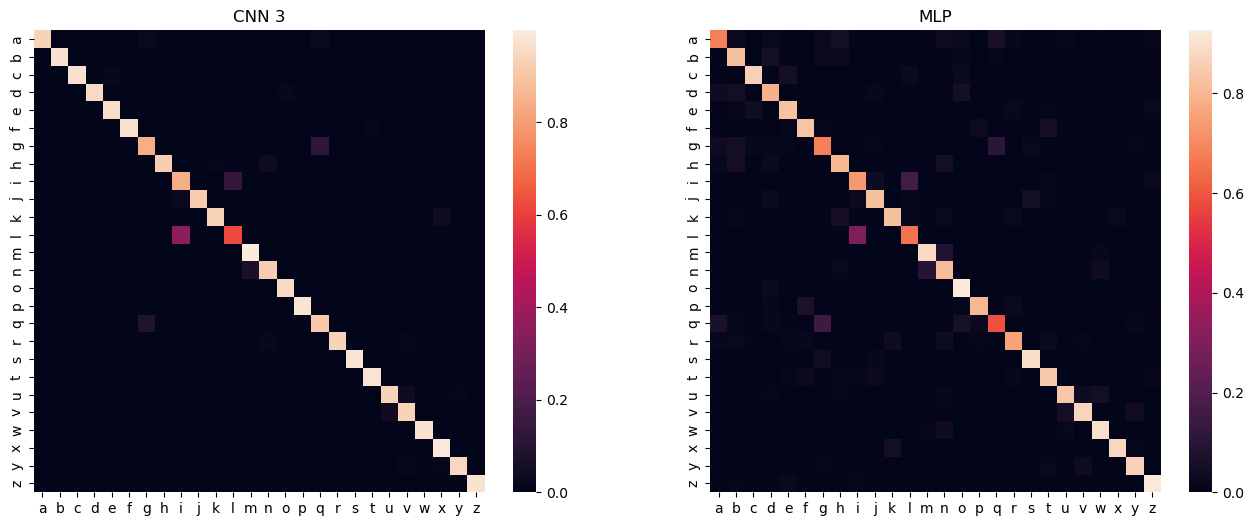

In [166]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
cnn3_accs = cm(y_test, y_pred_cnn3, "CNN 3")
plt.subplot(1,2,2)
mlp_accs = cm(y_test, y_pred_mlp, "MLP")

In [167]:
#Display per class accuracies in a table
df_accs = pd.DataFrame({
    "Class": labels,
    "CNN 3 Accuracy": cnn3_accs,
    "MLP Accuracy": mlp_accs
})

df_accs

,Class,CNN 3 Accuracy,MLP Accuracy
0,a,0.935199,0.677467
1,b,0.973490,0.820324
2,c,0.970760,0.861111
3,d,0.951471,0.788235
4,e,0.960699,0.826783
5,f,0.967599,0.829161
6,g,0.840473,0.677991
7,h,0.919708,0.801460
8,i,0.839650,0.734694
9,j,0.916176,0.823529


The confusion matrices show that both networks perform quite well for most classes, but a few classes are easily confused, such as "l" being confused for "i". The CNN only has 3 or 4 classes with lower accuracies, while the MLP has quite a few that are easily confused. The per-class accuracy table above summarizes this effect.

#### 2.4.3 McNemar's Test

As a final comparison, McNemar's test is used to see if the models are statistically different.

In [168]:
print(f"CNN3 vs. MLP: {mcnemar(y_pred_cnn3, y_pred_mlp, y_test)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")
print(f"MLP accuracy: {accuracy_score(y_test, y_pred_mlp)}")

CNN3 vs. MLP: 1578.1836804370091
CNN 3 accuracy: 0.9322072072072072
MLP accuracy: 0.8110923423423423


McNemar's test shows that there is a statistically significant difference between CNN 3 and the MLP. Given CNN 3's better AUC score and accuracy, we can determine that it is better than the multilayer perceptron.

## 4. Exceptional work - Transfer learning with VGG19

VGG19 (https://arxiv.org/abs/1409.1556) is a deep CNN that uses a series of 3x3 convolution layers with increasing number of filters, interleaved with max pooling layers. Architecture 2 in this report is somewhat similar to the VGG19 architecture, but VGG19 uses "blocks" of consecutive convolution layers before applying max pooling. Coincidentally, Architecture 2 and VGG19 have the same structure for the fully connected layers (except for the dropout used in Architecture 2). There are many options for integrating the pretrained weights from VGG19, and I decided on the following approach:

* Use the weights from the first convolution layer from the first three blocks in VGG19 as the weights for the three convolution layers in Architecture 2
* Use the same number of neurons for the fully-connected layer structure from VGG19

#### Dataset adjustments

There are a few changes that need to be made to the dataset in order to make it compatible with a network using the pretrained weights from VGG19. The minimum input size for VGG19 is 32x32, so the dataset has to be resized up to that size from its original size. The inputs must also be in three channels, so the grayscale channel must be copied into RGB channels.

In [88]:
#Transfer dataset

X_train_trnsf = np.concatenate((X_train_aug, X_train_aug, X_train_aug), axis=3)
X_test_trnsf = np.concatenate((X_test, X_test, X_test), axis=3) #duplicate the grayscale channel 3x to create rgb images

In [89]:
from keras.layers import Resizing

resize = Sequential([Resizing(32,32)])

X_train_trnsf = resize(X_train_trnsf)
X_test_trnsf = resize(X_test_trnsf)

#### Implementation
Keras provides a utility for loading in VGG19, pretrained on ImageNet, as a keras model. After loading in the model, the first convolution layer from the first three blocks is copied and the weights are labelled as untrainable. These layers are then integrated into Architecture 2.

In [81]:
from keras.applications.vgg19 import VGG19

vgg_model = VGG19(
    include_top=False, #just need to extract the weights, don't need the fully connected layers
    weights="imagenet",
    input_tensor=None,
    input_shape=(32,32,3),
    pooling="max",
    classes=26,
    classifier_activation="softmax",
)

80150528/80134624 [==============================] - 2s 0us/step


In [149]:
conv_layers = [vgg_model.get_layer(name) for name in ["block1_conv1", "block2_conv1", "block3_conv1"]]
for l in conv_layers: l.trainable = False #set pretrained layers as untrainable

In [150]:
from keras.layers import Input

#Integrate into CNN Architecture 2
cnn_transfer = Sequential([
    Input(shape=(32,32,3)),
    conv_layers[0], #substitute in the conv2d layers from vgg19 to capture the pretrained weights
    MaxPool2D(),
    conv_layers[1],
    MaxPool2D(),
    conv_layers[2],
    MaxPool2D(),
    Dropout(0.25),
    Flatten(),

    Dense(4096, activation="relu"),
    Dense(4096, activation="relu"),
    Dense(1000, activation="relu"), #using same structure of fully connected layers as VGG19 (not pretrained though)
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn_transfer.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics="accuracy")

#### Performance

In [151]:
hist_trnsf = cnn_transfer.fit(X_train_trnsf, y_train_ohe, batch_size=128, epochs=50, shuffle=True, validation_data=(X_test_trnsf, y_test_ohe), verbose=0)

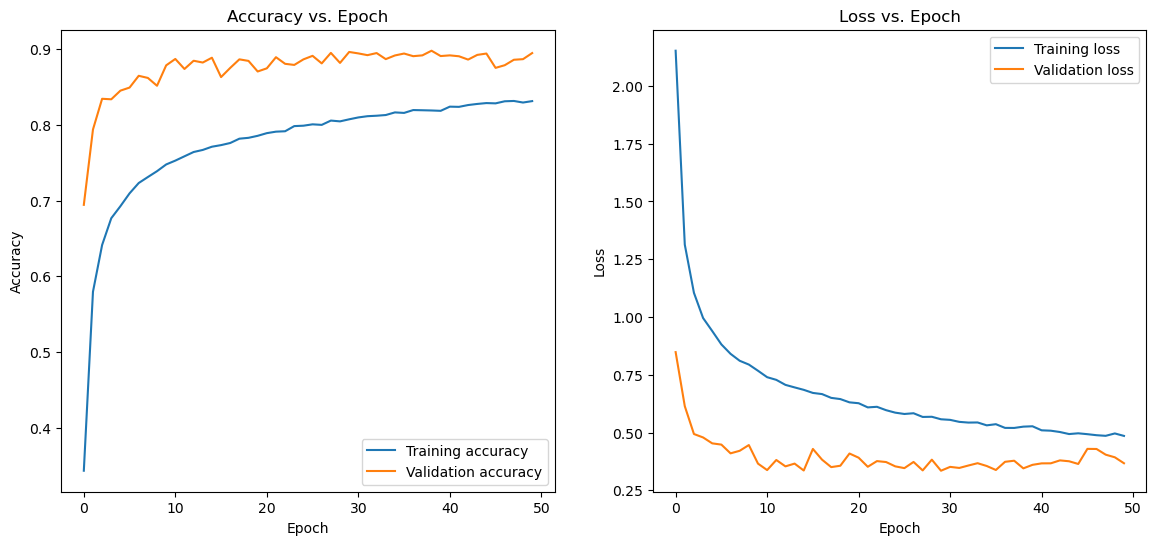

Test set accuracy: 0.8948198198198198


In [152]:
plot_performance(hist_trnsf)
y_pred_trnsf, y_score_trnsf = model_report(cnn_transfer, y_test, X_test_trnsf)

The model converges, and doesn't seem to suffer from increasing validation loss like previous models did. The accuracy is less than, but comparable to the accuracy of CNN 3. Before doing a statistical comparison to CNN 3, it could be interesting to compare the confusion matrices to see if the networks are making similar kinds of mistakes.

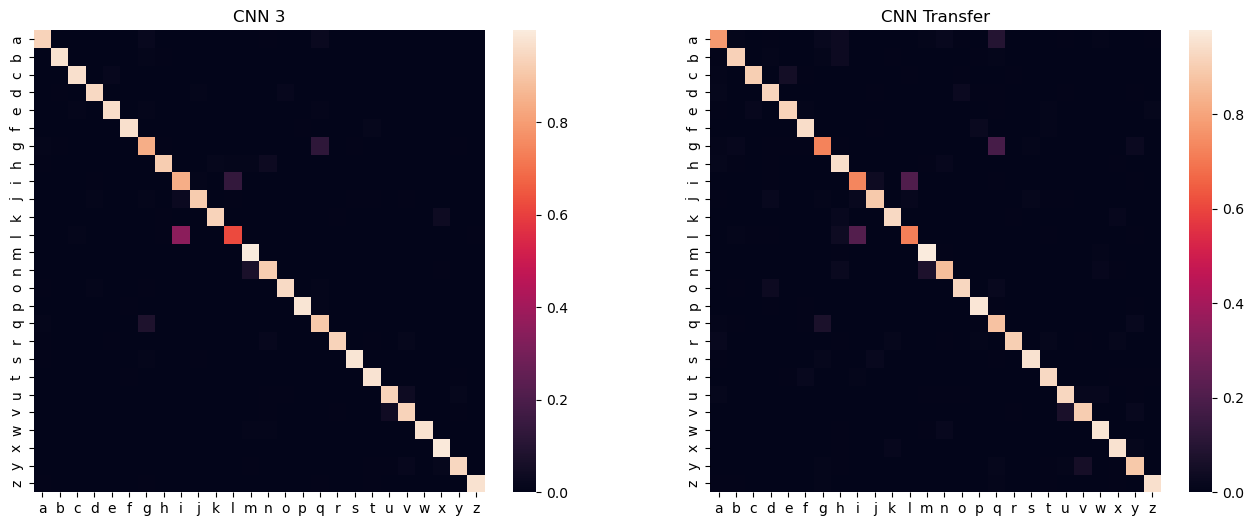

In [169]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
cnn3_accs = cm(y_test, y_pred_cnn3, "CNN 3")
plt.subplot(1,2,2)
trnsf_accs = cm(y_test, y_pred_trnsf, "CNN Transfer")

It looks like both networks are making similar mistakes. Interestingly though, the transfer learning model is much better at differentiating between "i" and "l" than CNN 3.

#### McNemar's Test Comparison to CNN 3



In [170]:
print(f"CNN 3 vs. CNN Transfer: {mcnemar(y_pred_trnsf, y_pred_cnn3, y_test)}")
print(f"CNN 3 accuracy: {accuracy_score(y_test, y_pred_cnn3)}")
print(f"Transfer accuracy: {accuracy_score(y_test, y_pred_trnsf)}")

CNN 3 vs. CNN Transfer: 282.49935732647816
CNN 3 accuracy: 0.9322072072072072
Transfer accuracy: 0.8948198198198198


McNemar's test shows that the models are statistically different, which means CNN 3 is the better model because of its higher accuracy. This is not completely surprising, since only a portion of VGG19's weights could be integrated into Architecture 2. Even so, the transfer learning model still performed nearly as good as CNN 3, so it is clear that the VGG19 weights pretrained on ImageNet are effective.